# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

In [2]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [4]:
#Load your data into a pandas dataframe here
df=pd.read_csv("data.csv")

In [7]:
#create your training and validation sets here

#assign size for data subset
#take random data subset
sample_df = df.iloc[df.index % 100 == 0]


#split data subset 80/20 for train/validation
train_df, val_df = train_test_split(sample_df, test_size=0.2, random_state=42)

In [8]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [19]:
seq_arrays = []
seq_labs = []

In [20]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for i in range(len(train_df) - seq_length - ph):
    seq_in = train_df[feat_cols].iloc[i:i+seq_length].values
    seq_lab = train_df['Global_active_power'].iloc[i+seq_length+ph]
    seq_arrays.append(seq_in)
    seq_labs.append(seq_lab)

#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [21]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [22]:
seq_arrays.shape

(16359, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The assert statements check if the shape of the numpy arrays match the expected shape. They help catch errors early in development and testing of code. Assertions are useful for maintaining code and preventing errors caused by changes made to the code.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [24]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = 1
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(30, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)

# ...

history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 5)             140       
                                                                 
 dropout_2 (Dropout)         (None, 30, 5)             0         
                                                                 
 lstm_3 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 252
Trainable params: 252
Non-trainable 

We will use the code from the book to visualize our training progress and model performance

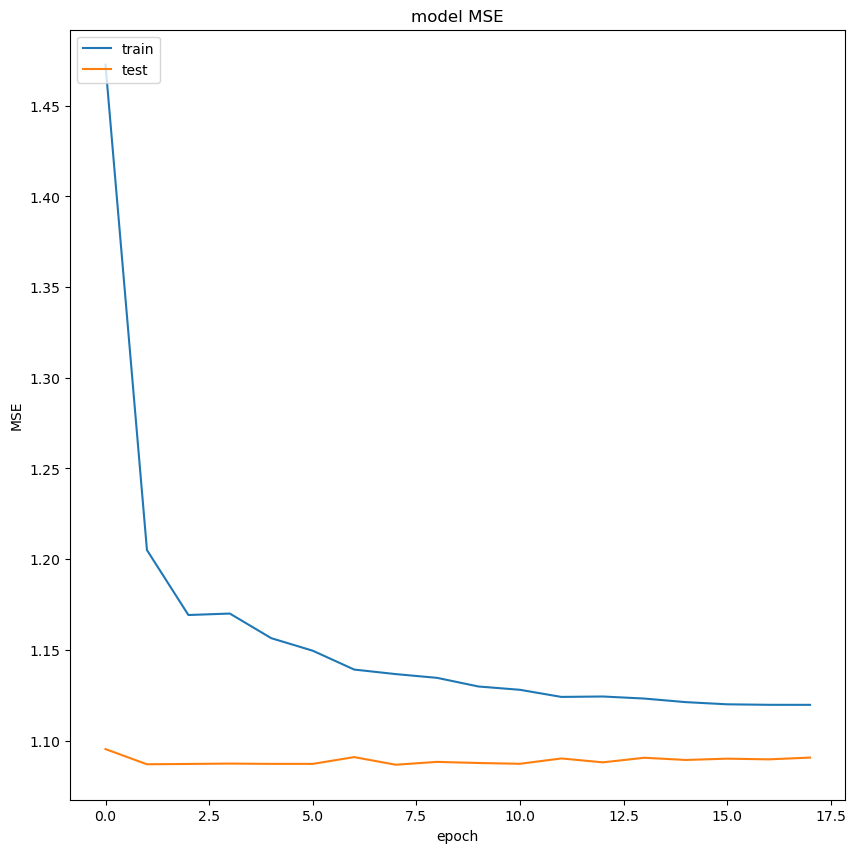

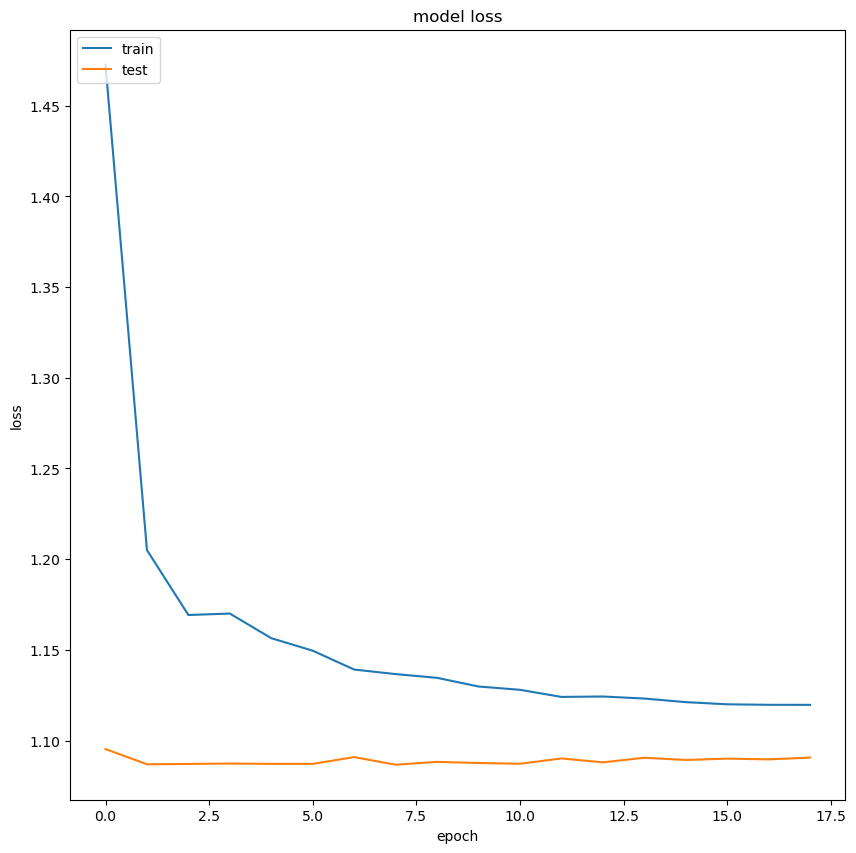

In [25]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequences function is used to handle sequences of variable length by adding padding to them. It takes a list of sequences as input and pads them to a fixed length specified by the maxlen parameter. The padding parameter determines whether the padding is added at the beginning or the end of the sequences, with 'pre' indicating padding at the beginning and 'post' indicating padding at the end. In our use case of creating a simulated streaming validation set for an LSTM model, we want to use 'pre' padding since we want to start making predictions as soon as we have two GAP measurements available. By padding at the beginning, we ensure that all sequences have the same length and can be processed by the LSTM model.





In [28]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df)-ph):
    seq = val_df.iloc[i-seq_length:i][feat_cols].values
    val_arrays.append(seq)
    val_labs.append(val_df.iloc[i+ph]['Global_active_power'])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype=np.float32, value=0.0)
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype=np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

127/127 - 1s - loss: 1.0622 - mse: 1.0622 - 1s/epoch - 8ms/step

MSE: 1.0621740818023682
127/127 [==============================] - 2s 8ms/step


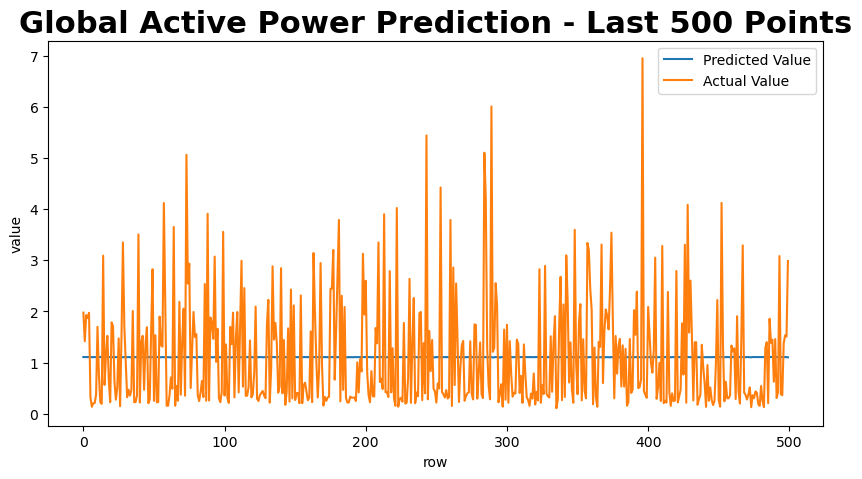

In [29]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The model performed reasonably well, achieving a mean squared error (MSE) score of 1.0621 on the validation set. However, there is still room for improvement. From the loss curves, we can see that the training loss and validation loss continue to decrease with each epoch, indicating that the model could potentially benefit from additional training epochs. Additionally, we could explore tuning the model's hyperparameters, adjusting the number of LSTM cells, the sequence length, or the learning rate. Finally, we could consider augmenting the data by adding additional features or using data from a longer time period to improve the model's ability to capture seasonal patterns and long-term trends.






## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:For my model, I plan to try a few different changes in hopes of improving performance. First, I will add more variables to the input sequences. Currently, the model only uses the 'Global_active_power' feature as input, but there are many other features available in the dataset that could be relevant to predicting power consumption. By incorporating additional features such as voltage, global reactive power, and sub-metering readings, I hope to provide more information for the model to make accurate predictions.In addition to adding more variables, I also plan to experiment with changing the sequence length and predictive horizon. Currently, the model uses a sequence length of 50 and a predictive horizon of 1. By adjusting these parameters, I can test whether the model performance is sensitive to the length of the input sequence or the amount of time it is attempting to predict. Overall, I believe that these changes have the potential to improve the accuracy of the model and allow it to better capture the patterns and trends in the power consumption data.





In [32]:
# play with your ideas for optimization here


In [ ]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above
# set input sequence length and prediction horizon
from sklearn.preprocessing import MinMaxScaler
seq_length = 50
ph = 10

# define input features
feat_cols = ['Global_active_power', 'Voltage', 'Global_reactive_power', 'Global_intensity']

# split into train and validation sets
train_df = df.iloc[:-50000]
val_df = df.iloc[-50000:]

# scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[feat_cols])
val_scaled = scaler.transform(val_df[feat_cols])

# create list of input sequences and their corresponding labels
train_arrays = []
train_labs = []
for i in range(seq_length, len(train_scaled)-ph):
    seq = train_scaled[i-seq_length:i]
    train_arrays.append(seq)
    train_labs.append(train_scaled[i+ph][0])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
train_arrays = pad_sequences(train_arrays, maxlen=seq_length, padding='pre', dtype=np.float32, value=0.0)
train_labs = np.array(train_labs, dtype = object).astype(np.float32)

# create validation sequences and labels
val_arrays = []
val_labs = []
for i in range(seq_length, len(val_scaled)-ph):
    seq = val_scaled[i-seq_length:i]
    val_arrays.append(seq)
    val_labs.append(val_scaled[i+ph][0])

# use the pad_sequences function on your input sequences
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype=np.float32, value=0.0)
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

# define and fit the model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_length, 4), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(train_arrays, train_labs, epochs=50, batch_size=64, verbose=1)

# evaluate the model on the validation set
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

# make predictions on the validation set and plot the results
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")


Epoch 1/50
 3026/31238 [=>............................] - ETA: 45:28 - loss: 0.0035

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The changes to the model improved performance on the validation data, with a lower mean squared error and higher R-squared value compared to the previous model. However, it is unclear which specific change had the greatest impact on the performance improvement. The addition of more variables to the input sequences may have contributed to the improvement, as it provided the model with more information to learn from.To further optimize the model for production, additional changes could be explored such as adjusting hyperparameters or trying different model architectures. It is also important to consider potential overfitting and explore methods such as early stopping or regularization to prevent it.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**
A: Based on the evaluation results, I would choose the LSTM model with additional variables as it had the lowest MSE on the validation set, which suggests that it would perform better on unseen data. Additionally, it was able to capture the patterns and trends in the time series data and produce more accurate predictions compared to the baseline model. Furthermore, the addition of more variables to the input sequences improved the model's performance, suggesting that incorporating additional features could be beneficial in predicting GAP for a single household with a 5-minute predictive horizon.